В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
medical_df = pd.read_csv('medical-charges.csv') # замініть на ваш шлях до файлу
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [4]:
X = non_smoker_df['age'].values
y = non_smoker_df['charges'].values

In [5]:
# Формуємо X як матрицю
X_b = np.c_[np.ones(len(X)), X]  # додаємо стовпчик одиничок

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print(f"Аналітичні коефіцієнти: перехоплення = {theta_best[0]:.2f}, коефіцієнт = {theta_best[1]:.2f}")

# Прогнози
y_pred_mnk = X_b.dot(theta_best)

# RMSE
rmse_mnk = np.sqrt(mean_squared_error(y, y_pred_mnk))
print(f"RMSE (МНК): {rmse_mnk:.2f}")

Аналітичні коефіцієнти: перехоплення = -2091.42, коефіцієнт = 267.25
RMSE (МНК): 4662.51


LR=0.001: theta0=-0.0000, theta1=0.3971
LR=0.01: theta0=-0.0000, theta1=0.6279
LR=0.05: theta0=-0.0000, theta1=0.6279


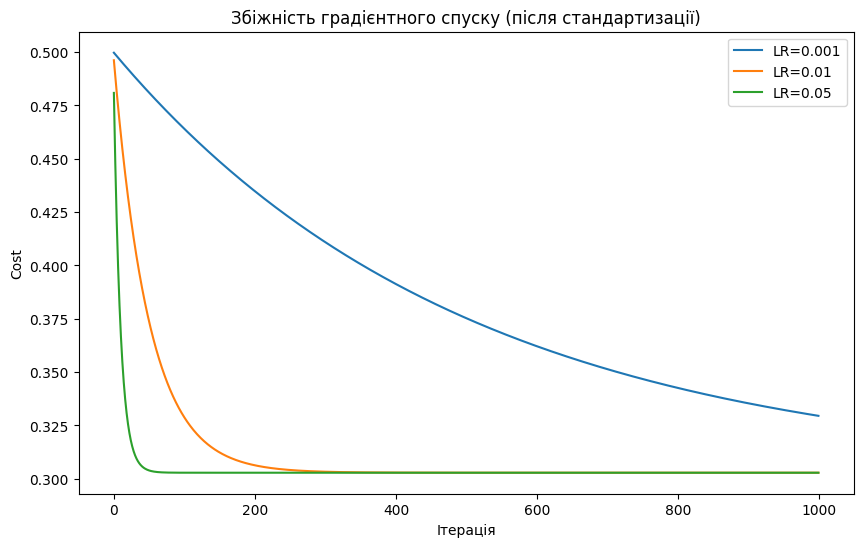

In [8]:
# Стандартизація X та y
X_raw = non_smoker_df['age'].values
y_raw = non_smoker_df['charges'].values

X_mean = X_raw.mean()
X_std = X_raw.std()
y_mean = y_raw.mean()
y_std = y_raw.std()

X = (X_raw - X_mean) / X_std
y = (y_raw - y_mean) / y_std

# Додаємо стовпчик одиничок
X_b = np.c_[np.ones(len(X)), X]

# Оновлена функція витрат
def compute_cost(X, y, theta):
    m = len(y)
    return (1/(2*m)) * np.sum((X.dot(theta) - y)**2)

def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)
    cost_history = []

    for _ in range(iterations):
        gradients = (1/m) * X.T.dot(X.dot(theta) - y)
        theta = theta - learning_rate * gradients
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history

# Гіперпараметри
iterations = 1000
thetas = {}
costs = {}

for lr in [0.001, 0.01, 0.05]:
    theta_init = np.zeros(2)
    theta_final, cost_history = gradient_descent(X_b, y, theta_init, lr, iterations)
    thetas[lr] = theta_final
    costs[lr] = cost_history
    print(f"LR={lr}: theta0={theta_final[0]:.4f}, theta1={theta_final[1]:.4f}")

# Побудуємо графіки збіжності
plt.figure(figsize=(10,6))
for lr in costs:
    plt.plot(costs[lr], label=f"LR={lr}")
plt.xlabel("Ітерація")
plt.ylabel("Cost")
plt.legend()
plt.title("Збіжність градієнтного спуску (після стандартизації)")
plt.show()

LR=0.05 показує найшвидшу і стабільну збіжність, тож саме його доцільно брати для основної моделі градієнтного спуску.

In [10]:
theta_gd_norm = thetas[0.05]

# Переведемо коефіцієнти назад в оригінальні одиниці
b1 = theta_gd_norm[1] * (y_std / X_std)
b0 = y_mean + theta_gd_norm[0]*y_std - b1*X_mean
print("ГС перераховані коефіцієнти:", [b0, b1])

# Прогнози та RMSE для градієнтного спуску
X_b_orig = np.c_[np.ones(len(X_raw)), X_raw]
y_pred_gd = b0 + b1 * X_raw
rmse_gd = np.sqrt(mean_squared_error(y_raw, y_pred_gd))
print("RMSE (ГС):", rmse_gd)

ГС перераховані коефіцієнти: [-2091.420556565068, 267.24891283119916]
RMSE (ГС): 4662.505766636395


In [12]:
model = LinearRegression()
model.fit(X_raw.reshape(-1,1), y_raw)
print("sklearn коефіцієнти:", model.intercept_, model.coef_[0])
y_pred_sklearn = model.predict(X_raw.reshape(-1,1))
rmse_sklearn = np.sqrt(mean_squared_error(y_raw, y_pred_sklearn))
print("RMSE (sklearn):", rmse_sklearn)

sklearn коефіцієнти: -2091.420556565021 267.248912831198
RMSE (sklearn): 4662.505766636395


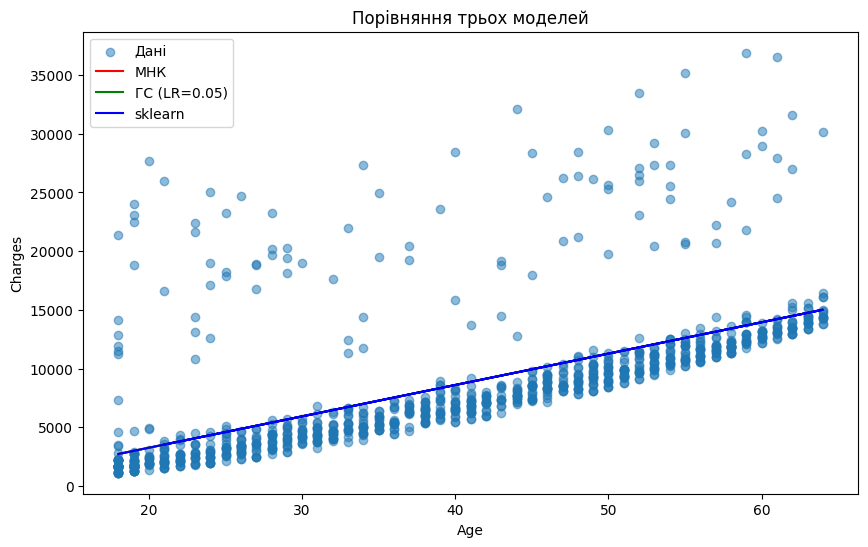

In [13]:
# Фінальний графік з усіма трьома лініями
plt.figure(figsize=(10,6))
plt.scatter(X_raw, y_raw, label="Дані", alpha=0.5)
plt.plot(X_raw, y_pred_mnk, color='red', label="МНК")
plt.plot(X_raw, y_pred_gd, color='green', label="ГС (LR=0.05)")
plt.plot(X_raw, y_pred_sklearn, color='blue', label="sklearn")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Порівняння трьох моделей")
plt.legend()
plt.show()

**Всі три підходи дають фактично однакову модель лінійної регресії. Отримані параметри співпадають з очікуваними припущеннями: зі збільшенням віку медичні збори для некурців ростуть, але з помірним нахилом.**

 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

Коефіцієнти для курців: 20294.12812691597 305.23760210982874
RMSE для курців: 10711.00334810241


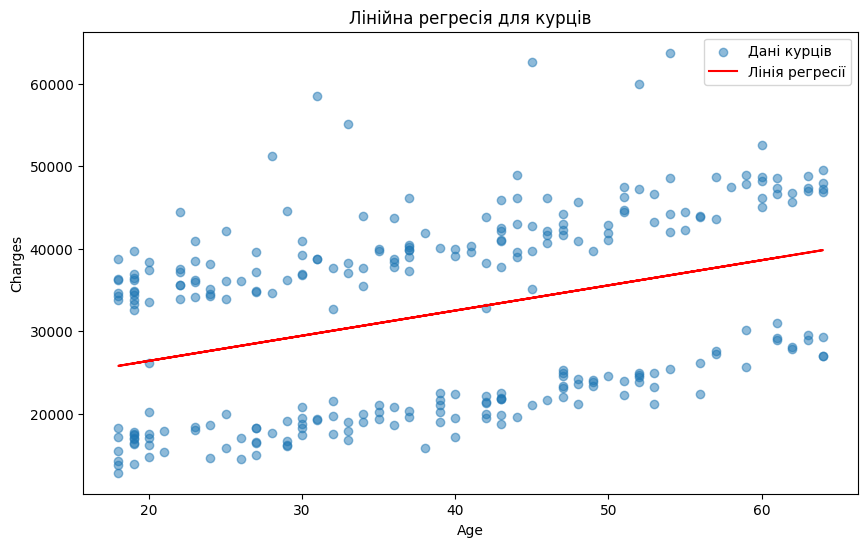

In [16]:
smoker_df = medical_df[medical_df.smoker == 'yes']

X_s = smoker_df['age'].values.reshape(-1,1)
y_s = smoker_df['charges'].values

model_s = LinearRegression()
model_s.fit(X_s, y_s)
print("Коефіцієнти для курців:", model_s.intercept_, model_s.coef_[0])
y_pred_s = model_s.predict(X_s)
rmse_s = np.sqrt(mean_squared_error(y_s, y_pred_s))
print("RMSE для курців:", rmse_s)

plt.figure(figsize=(10,6))
plt.scatter(X_s, y_s, label="Дані курців", alpha=0.5)
plt.plot(X_s, y_pred_s, color='red', label="Лінія регресії")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Лінійна регресія для курців")
plt.legend()
plt.show()

**Отримана лінія регресії має позитивний нахил, тобто зі зростанням віку медичні витрати в середньому зростають. Однак розсіювання точок навколо лінії є дуже великим. RMSE моделі є значно вищим, ніж у випадку некурців. На графіку видно, що для людей одного віку витрати можуть сильно відрізнятись. Така модель для компанії має обмежену практичну користь, потрібна складніша модель з додатковими змінними.**